# Creating training data

## Setup

In [1]:
from pathlib import Path

import pandas as pd
from datasets import load_dataset
from IPython.display import display
from sklearn.model_selection import train_test_split
from slugify import slugify
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

In [3]:
def get_min_count(dic, lang):
    """Get the minimal value in a Dict[(lang, attr)] -> count baseed on lang"""
    count = 10000000
    for ((key, _), value) in dic.items():
        if key == lang:
            if value < count:
                count = value
    return count

## Loading Bibles

In [4]:
bibles = []
bibles_path = "../data/books_labels/"
total = sum(1 for _ in Path(bibles_path).rglob("*.tsv"))
for bible_path in tqdm(Path(bibles_path).rglob("*.tsv"), total=total):
    bible = pd.read_csv(bible_path, sep="\t")
    bibles.append(bible)
bibles = pd.concat(bibles)
bibles.drop(columns=bibles.columns[0], axis=1, inplace=True)

  0%|          | 0/11281 [00:00<?, ?it/s]

In [5]:
bibles.head()

,id,text,codebook,language,book_file_name,file_name_translation,source,year,genre,genre-multilabel,testament,division
0,b.DEU.001.001,Voici les paroles que Moïse adressa à tout Isr...,DEU,FRE,DEU_SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),zefania,1910,law,law,old,Pentateuch
1,b.DEU.001.002,"Il y a onze journées depuis Horeb, par le chem...",DEU,FRE,DEU_SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),zefania,1910,law,law,old,Pentateuch
2,b.DEU.001.003,"Dans la quarantième année, au onzième mois, le...",DEU,FRE,DEU_SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),zefania,1910,law,law,old,Pentateuch
3,b.DEU.001.004,"C'était après qu'il eut battu Sihon, roi des A...",DEU,FRE,DEU_SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),zefania,1910,law,law,old,Pentateuch
4,b.DEU.001.005,"De l'autre côté du Jourdain, dans le pays de M...",DEU,FRE,DEU_SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),SF_2009-01-20_FRE_FREN_(FRENCH LOUIS SEGOND),zefania,1910,law,law,old,Pentateuch


In [6]:
bibles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4706270 entries, 0 to 878
Data columns (total 12 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   id                     object
 1   text                   object
 2   codebook               object
 3   language               object
 4   book_file_name         object
 5   file_name_translation  object
 6   source                 object
 7   year                   int64 
 8   genre                  object
 9   genre-multilabel       object
 10  testament              object
 11  division               object
dtypes: int64(1), object(11)
memory usage: 466.8+ MB


Removing null and near duplicates in text.

In [7]:
bibles.dropna(inplace=True)

In [8]:
bibles["slug"] = bibles.text.progress_apply(slugify)

  0%|          | 0/4702154 [00:00<?, ?it/s]

In [9]:
bibles.drop_duplicates(subset=["slug"], inplace=True)

In [10]:
bibles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3837710 entries, 0 to 878
Data columns (total 13 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   id                     object
 1   text                   object
 2   codebook               object
 3   language               object
 4   book_file_name         object
 5   file_name_translation  object
 6   source                 object
 7   year                   int64 
 8   genre                  object
 9   genre-multilabel       object
 10  testament              object
 11  division               object
 12  slug                   object
dtypes: int64(1), object(12)
memory usage: 409.9+ MB


Distribution of texts by language.

In [11]:
bibles.language.value_counts()

ENG    701781
SPA    461185
FRE    460266
GER    444671
CZE    118526
ITA    116811
HEB    115097
RUS     90822
LAT     86215
GRC     80885
CHI     67327
VIE     56476
HUN     56346
ARA     56112
SWE     55511
NOR     55034
POR     54163
FIN     51947
RUM     48983
DAN     45402
CEB     35541
BUL     35305
ALB     32263
MAR     28294
BEL     28289
SCR     28288
HIN     28266
TGL     28260
TAM     28220
THA     28201
HAT     28129
NL_     28103
ESP     28085
XKL     28078
KOR     27714
TUR     27146
AZB     26535
NDS     16857
PON      9520
BAQ      7250
CKB      7223
SYR      7210
JAM      7207
ZIA      7154
WIU      7139
SHU      7134
SWA      7109
UND      7080
COP      6930
YBY      6838
CHA      6630
GAE      3630
GOT      3544
BLA       978
Name: language, dtype: int64

Obtaining the approximate number of words per text.

In [12]:
bibles["length"] = bibles.text.progress_apply(lambda x: sum(1 for s in str(x).split() if s.strip()))

  0%|          | 0/3837710 [00:00<?, ?it/s]

Filtering out texts shorter than ~500 words. Unsure on how this affects non Latin alphabets.

In [13]:
bibles = bibles.groupby("length").filter(lambda x: len(x) > 500)

Filtering out languages with fewer than 5000 texts. This is an arbitray value chosen for training purposes.

In [14]:
bibles = bibles.groupby("language").filter(lambda x: len(x) > 5000)

In [15]:
bibles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3822826 entries, 0 to 878
Data columns (total 14 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   id                     object
 1   text                   object
 2   codebook               object
 3   language               object
 4   book_file_name         object
 5   file_name_translation  object
 6   source                 object
 7   year                   int64 
 8   genre                  object
 9   genre-multilabel       object
 10  testament              object
 11  division               object
 12  slug                   object
 13  length                 int64 
dtypes: int64(2), object(12)
memory usage: 437.5+ MB


## Create language-balanced datasets for testament, division, and genre

In [16]:
bibles.groupby(["testament", "division", "genre"])[["text"]].count()

text
testament division   genre              
new       Gospel     gospel       707023
          Letters    letter       411299
          Revelation apocalyptic   61438
old       Historical historical   785498
          Pentateuch historical   311763
                     law          347131
          Prophetic  apocalyptic  150514
                     historical     5696
                     lyric         17499
                     prophecy     469661
          Wisdom     lyric        309518
                     wisdom       245786

### Testament

For each language, we randomly sample as many documents as the smaller grouping has.

In [17]:
lang_testament_counts = bibles.groupby(["language", "testament"])["text"].count().to_dict()
lang_testament_counts

{('ALB', 'new'): 8412,
 ('ALB', 'old'): 23843,
 ('ARA', 'new'): 14350,
 ('ARA', 'old'): 41762,
 ('AZB', 'new'): 7123,
 ('AZB', 'old'): 19412,
 ('BAQ', 'new'): 7250,
 ('BEL', 'new'): 7247,
 ('BEL', 'old'): 21042,
 ('BUL', 'new'): 14474,
 ('BUL', 'old'): 20830,
 ('CEB', 'new'): 14506,
 ('CEB', 'old'): 20975,
 ('CHA', 'new'): 4353,
 ('CHA', 'old'): 2277,
 ('CHI', 'new'): 18092,
 ('CHI', 'old'): 48656,
 ('CKB', 'new'): 7222,
 ('COP', 'new'): 6930,
 ('CZE', 'new'): 35367,
 ('CZE', 'old'): 83159,
 ('DAN', 'new'): 11467,
 ('DAN', 'old'): 33926,
 ('ENG', 'new'): 245916,
 ('ENG', 'old'): 452976,
 ('ESP', 'new'): 7242,
 ('ESP', 'old'): 20839,
 ('FIN', 'new'): 13764,
 ('FIN', 'old'): 38183,
 ('FRE', 'new'): 113579,
 ('FRE', 'old'): 346382,
 ('GER', 'new'): 164847,
 ('GER', 'old'): 278540,
 ('GRC', 'new'): 34393,
 ('GRC', 'old'): 46437,
 ('HAT', 'new'): 7239,
 ('HAT', 'old'): 20728,
 ('HEB', 'new'): 7241,
 ('HEB', 'old'): 107833,
 ('HIN', 'new'): 7258,
 ('HIN', 'old'): 21002,
 ('HUN', 'new'): 1447

In [52]:
testaments = []
for testament in tqdm(bibles.testament.unique()):
    for lang in tqdm(bibles.language.unique()):
        subbible = (bibles
            .query(f"language == '{lang}' and testament == '{testament}'")
        )[["text", "testament", "language"]]
        if not subbible.empty:
            testaments.append(subbible.sample(get_min_count(lang_testament_counts, lang)))
testaments = pd.concat(testaments)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [53]:
testaments.groupby(["language", "testament"]).count()

text
language testament       
ALB      new         8412
         old         8412
ARA      new        14350
         old        14350
AZB      new         7123
...                   ...
WIU      new         7129
XKL      new         7239
         old         7239
YBY      new         6809
ZIA      new         7069

[91 rows x 1 columns]

In order to make models comparable, we only keep languages for which all the groups in testament are present.

In [55]:
testaments_count = testaments.testament.unique().size
testaments_langs = testaments.groupby("language")[["testament"]].agg(
    lambda x: len(set(x)) == testaments_count
).query("testament == True").index
balanced_testaments = testaments[testaments.language.isin(testaments_langs)]
balanced_testaments.rename(columns={"testament": "label"}, inplace=True)
balanced_testaments.groupby(["language", "label"]).count()

/home/javierr/.pyenv/versions/3.9.7/envs/bibles/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


text
language label       
ALB      new     8412
         old     8412
ARA      new    14350
         old    14350
AZB      new     7123
...               ...
TUR      old     6788
VIE      new    14501
         old    14501
XKL      new     7239
         old     7239

[80 rows x 1 columns]

In [56]:
trains = []
validations = []
tests = []
for lang in tqdm(balanced_testaments.language.unique()):
    subset = balanced_testaments.query(f"language == '{lang}'")
    train, rest = train_test_split(subset, train_size=0.8, stratify=subset[["label"]])
    validation, test = train_test_split(rest, train_size=0.5, stratify=rest[["label"]])
    trains.append(train)
    validations.append(validation)
    tests.append(test)
testament_train = pd.concat(trains).sample(frac=1)
testament_validation = pd.concat(validations).sample(frac=1)
testament_test = pd.concat(tests).sample(frac=1)

  0%|          | 0/40 [00:00<?, ?it/s]

In [57]:
testament_train.to_csv("../data/datasets/testament_train.csv", index=None)
testament_validation.to_csv("../data/datasets/testament_validation.csv", index=None)
testament_test.to_csv("../data/datasets/testament_test.csv", index=None)

In [58]:
print("train", testament_train.language.unique())
print("validation", testament_validation.language.unique())
print("test", testament_test.language.unique())

train ['FRE' 'POR' 'CHI' 'SPA' 'GRC' 'BEL' 'ALB' 'TAM' 'ENG' 'HUN' 'GER' 'SWE'
 'CZE' 'THA' 'DAN' 'ITA' 'CEB' 'VIE' 'ARA' 'AZB' 'TUR' 'RUM' 'FIN' 'TGL'
 'MAR' 'LAT' 'RUS' 'NOR' 'HAT' 'BUL' 'ESP' 'XKL' 'SCR' 'PON' 'HIN' 'NDS'
 'KOR' 'HEB' 'NL_' 'CHA']
validation ['ENG' 'AZB' 'SPA' 'CEB' 'BUL' 'TUR' 'GRC' 'HUN' 'GER' 'CHI' 'RUM' 'CZE'
 'FRE' 'ITA' 'SWE' 'ARA' 'FIN' 'RUS' 'XKL' 'NL_' 'SCR' 'HEB' 'TGL' 'TAM'
 'HIN' 'LAT' 'ESP' 'NOR' 'HAT' 'DAN' 'POR' 'BEL' 'KOR' 'VIE' 'MAR' 'PON'
 'THA' 'ALB' 'NDS' 'CHA']
test ['FRE' 'RUM' 'POR' 'ARA' 'DAN' 'SPA' 'ENG' 'LAT' 'GER' 'NDS' 'BEL' 'ALB'
 'VIE' 'CHI' 'HUN' 'KOR' 'FIN' 'RUS' 'ITA' 'TAM' 'SWE' 'CHA' 'GRC' 'NOR'
 'HEB' 'CEB' 'CZE' 'TGL' 'ESP' 'THA' 'TUR' 'HIN' 'XKL' 'HAT' 'NL_' 'MAR'
 'BUL' 'SCR' 'AZB' 'PON']


### Genre

In [74]:
def generate_splits(bibles, attribute):
    lang_attr_counts = bibles.groupby(["language", attribute])["text"].count().to_dict()
    attrs = []
    for attr in tqdm(bibles[attribute].unique()):
        for lang in tqdm(bibles.language.unique()):
            subbible = (bibles
                .query(f"language == '{lang}' and {attribute} == '{attr}'")
            )[["text", attribute, "language"]]
            if not subbible.empty:
                attrs.append(subbible.sample(get_min_count(lang_attr_counts, lang)))
    attrs = pd.concat(attrs)
    attrs_count = attrs[attribute].unique().size
    attrs_langs = attrs.groupby("language")[[attribute]].agg(
        lambda x: len(set(x)) == attrs_count
    ).query(f"{attribute} == True").index
    balanced_attrs = attrs[attrs.language.isin(attrs_langs)]
    balanced_attrs.rename(columns={attribute: "label"}, inplace=True)
    trains = []
    validations = []
    tests = []
    for lang in tqdm(balanced_attrs.language.unique()):
        subset = balanced_attrs.query(f"language == '{lang}'")
        train, rest = train_test_split(subset, train_size=0.8, stratify=subset[["label"]])
        validation, test = train_test_split(rest, train_size=0.5, stratify=rest[["label"]])
        trains.append(train)
        validations.append(validation)
        tests.append(test)
    attr_train = pd.concat(trains).sample(frac=1)
    attr_validation = pd.concat(validations).sample(frac=1)
    attr_test = pd.concat(tests).sample(frac=1)
    attr_train.to_csv(f"../data/datasets/{attribute}_train.csv", index=None)
    attr_validation.to_csv(f"../data/datasets/{attribute}_validation.csv", index=None)
    attr_test.to_csv(f"../data/datasets/{attribute}_test.csv", index=None)
    print("train", attr_train.language.unique())
    print("validation", attr_validation.language.unique())
    print("test", attr_test.language.unique())

In [75]:
generate_splits(bibles, "genre")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

/home/javierr/.pyenv/versions/3.9.7/envs/bibles/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


  0%|          | 0/37 [00:00<?, ?it/s]

train ['SPA' 'GER' 'CZE' 'HUN' 'ENG' 'FRE' 'SWE' 'TAM' 'BEL' 'ITA' 'NOR' 'CEB'
 'RUM' 'LAT' 'KOR' 'HEB' 'ARA' 'CHI' 'AZB' 'GRC' 'RUS' 'POR' 'ESP' 'VIE'
 'DAN' 'XKL' 'SCR' 'HAT' 'BUL' 'NL_' 'THA' 'MAR' 'ALB' 'TGL' 'TUR' 'HIN'
 'FIN']
validation ['ENG' 'HUN' 'GER' 'FRE' 'NOR' 'RUS' 'POR' 'ALB' 'ARA' 'GRC' 'SPA' 'CZE'
 'BUL' 'ITA' 'SWE' 'SCR' 'DAN' 'CHI' 'RUM' 'HIN' 'VIE' 'NL_' 'ESP' 'FIN'
 'KOR' 'MAR' 'THA' 'CEB' 'LAT' 'TUR' 'BEL' 'HAT' 'XKL' 'AZB' 'TAM' 'TGL'
 'HEB']
test ['ENG' 'CZE' 'TAM' 'FRE' 'HAT' 'LAT' 'CHI' 'ITA' 'THA' 'SPA' 'ALB' 'GER'
 'GRC' 'XKL' 'ARA' 'RUS' 'NL_' 'ESP' 'HIN' 'FIN' 'HUN' 'MAR' 'KOR' 'AZB'
 'DAN' 'CEB' 'TUR' 'NOR' 'BUL' 'HEB' 'SWE' 'BEL' 'RUM' 'POR' 'VIE' 'TGL'
 'SCR']


### Division

In [76]:
generate_splits(bibles, "division")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

/home/javierr/.pyenv/versions/3.9.7/envs/bibles/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


  0%|          | 0/37 [00:00<?, ?it/s]

train ['GER' 'ENG' 'TAM' 'RUS' 'HUN' 'ARA' 'FRE' 'FIN' 'ITA' 'LAT' 'SPA' 'RUM'
 'BUL' 'CZE' 'VIE' 'TUR' 'DAN' 'CHI' 'THA' 'ALB' 'SCR' 'HAT' 'SWE' 'POR'
 'NOR' 'GRC' 'BEL' 'CEB' 'MAR' 'XKL' 'HIN' 'AZB' 'TGL' 'KOR' 'ESP' 'NL_'
 'HEB']
validation ['GRC' 'FRE' 'LAT' 'POR' 'ENG' 'CZE' 'GER' 'ITA' 'VIE' 'BEL' 'CHI' 'SPA'
 'HUN' 'HAT' 'ALB' 'KOR' 'FIN' 'NOR' 'SWE' 'XKL' 'RUS' 'SCR' 'RUM' 'TAM'
 'CEB' 'NL_' 'ARA' 'AZB' 'DAN' 'TGL' 'HEB' 'MAR' 'BUL' 'HIN' 'THA' 'ESP'
 'TUR']
test ['ENG' 'NOR' 'GER' 'FRE' 'LAT' 'SPA' 'HAT' 'NL_' 'KOR' 'BUL' 'SCR' 'CZE'
 'HEB' 'POR' 'TUR' 'ALB' 'DAN' 'MAR' 'ITA' 'GRC' 'CHI' 'AZB' 'RUM' 'ESP'
 'RUS' 'THA' 'TGL' 'TAM' 'FIN' 'BEL' 'SWE' 'ARA' 'VIE' 'CEB' 'HIN' 'HUN'
 'XKL']


## Stats

In [18]:
csvs = []
csvs_path = "../data/datasets/"
total = sum(1 for _ in Path(csvs_path).rglob("*.csv"))
for dataset in tqdm(Path(csvs_path).rglob("*.csv"), total=total):
    dataset_csv = pd.read_csv(dataset)
    dataset_csv["config"] = dataset.name.split("_")[0]
    csvs.append(dataset_csv)
csvs = pd.concat(csvs)

  0%|          | 0/9 [00:00<?, ?it/s]

In [19]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(csvs.groupby(["language", "config", "label"]).count())

text  year  century  codebook
language config    label                                    
ALB      division  Gospel       424   424      424       424
                   Historical   424   424      424       424
                   Letters      424   424      424       424
                   Pentateuch   424   424      424       424
                   Prophetic    424   424      424       424
...                             ...   ...      ...       ...
XKL      genre     lyric       1548  1548     1548      1548
                   prophecy    1548  1548     1548      1548
                   wisdom      1548  1548     1548      1548
         testament new         6718  6718     6718      6718
                   old         6680  6680     6680      6680

[635 rows x 4 columns]

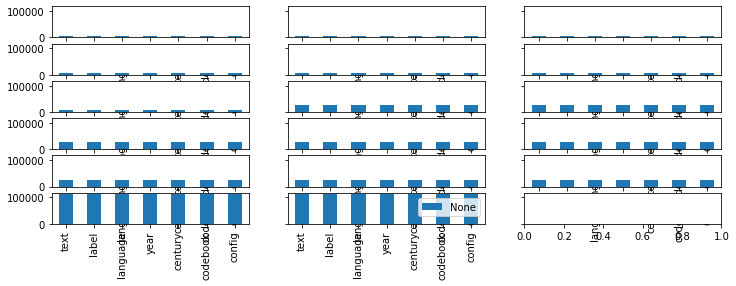

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# csvs.groupby(["language", "config", "label"]).count().plot()

grouped = csvs.query("language == 'SPA'").groupby(["config", "label"])

ncols=3
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).count().plot(ax=ax, kind="bar")

ax.legend()
plt.show()

## Adding year and codebook to the dataset

In [21]:
text2year = {text.strip(): int(year) for text, year in bibles[["text", "year"]].set_index("text")["year"].to_dict().items()}
text2code = {text.strip(): code for text, code in bibles[["text", "codebook"]].set_index("text")["codebook"].to_dict().items()}

In [22]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

def get_century(year):
    if year == 0:
        return "unk"
    elif 0 < year <= 1500:
        return "15th"
    elif 1500 < year <= 1600:
        return "16th"
    elif 1600 < year <= 1700:
        return "17th"
    elif 1700 < year <= 1800:
        return "18th"
    elif 1800 < year <= 1900:
        return "19th"
    elif 1900 < year <= 2000:
        return "20th"
    elif 2000 <  year:
        return "21st"
    else:  # BC
        return f"{ordinal(((abs(year) - 1) // 100) + 1)}BC"

for filepath in Path("../data/datasets").rglob("*.csv"):
    print(filepath)
    df = pd.read_csv(filepath)
    df["year"] = df.text.progress_apply(lambda x: text2year.get(x.strip(), 0))
    df["century"] = df.year.progress_apply(get_century)
    df["codebook"] = df.text.progress_apply(lambda x: text2code.get(x.strip(), "UNK"))
    df.to_csv(filepath, index=None)

../data/datasets/genre_test.csv


  0%|          | 0/161517 [00:00<?, ?it/s]

  0%|          | 0/161517 [00:00<?, ?it/s]

  0%|          | 0/161517 [00:00<?, ?it/s]

../data/datasets/testament_test.csv


  0%|          | 0/216511 [00:00<?, ?it/s]

  0%|          | 0/216511 [00:00<?, ?it/s]

  0%|          | 0/216511 [00:00<?, ?it/s]

../data/datasets/genre_train.csv


  0%|          | 0/1291986 [00:00<?, ?it/s]

  0%|          | 0/1291986 [00:00<?, ?it/s]

  0%|          | 0/1291986 [00:00<?, ?it/s]

../data/datasets/testament_train.csv


  0%|          | 0/1570633 [00:00<?, ?it/s]

  0%|          | 0/1570633 [00:00<?, ?it/s]

  0%|          | 0/1570633 [00:00<?, ?it/s]

../data/datasets/testament_validation.csv


  0%|          | 0/216493 [00:00<?, ?it/s]

  0%|          | 0/216493 [00:00<?, ?it/s]

  0%|          | 0/216493 [00:00<?, ?it/s]

../data/datasets/division_validation.csv


  0%|          | 0/39452 [00:00<?, ?it/s]

  0%|          | 0/39452 [00:00<?, ?it/s]

  0%|          | 0/39452 [00:00<?, ?it/s]

../data/datasets/genre_validation.csv


  0%|          | 0/161497 [00:00<?, ?it/s]

  0%|          | 0/161497 [00:00<?, ?it/s]

  0%|          | 0/161497 [00:00<?, ?it/s]

../data/datasets/division_test.csv


  0%|          | 0/39468 [00:00<?, ?it/s]

  0%|          | 0/39468 [00:00<?, ?it/s]

  0%|          | 0/39468 [00:00<?, ?it/s]

../data/datasets/division_train.csv


  0%|          | 0/315607 [00:00<?, ?it/s]

  0%|          | 0/315607 [00:00<?, ?it/s]

  0%|          | 0/315607 [00:00<?, ?it/s]

In [23]:
csvs = []
csvs_path = "../data/datasets/"
total = sum(1 for _ in Path(csvs_path).rglob("*.csv"))
for dataset in tqdm(Path(csvs_path).rglob("*.csv"), total=total):
    dataset_csv = pd.read_csv(dataset)
    dataset_csv["config"] = dataset.name.split("_")[0]
    csvs.append(dataset_csv)
csvs = pd.concat(csvs)

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(csvs.groupby(["language", "century", "config"]).count())

text   label    year  codebook
language century config                                     
ALB      unk     division     2968    2968    2968      2968
                 genre       14416   14416   14416     14416
                 testament   15547   15547   15547     15547
ARA      unk     division     5096    5096    5096      5096
                 genre       24712   24712   24712     24712
                 testament   26593   26593   26593     26593
AZB      unk     division     2513    2513    2513      2513
                 genre        7800    7800    7800      7800
                 testament   13179   13179   13179     13179
BEL      unk     division     2590    2590    2590      2590
                 genre       12472   12472   12472     12472
                 testament   13413   13413   13413     13413
BUL      20th    division     1117    1117    1117      1117
                 genre        2273    2273    2273      2273
                 testament    6678    6678    6678      6678
         unk     division     4056    4056    4056      4056
                 genre       13159   13159   13159     13159
                 testament   20135   20135   20135     20135
CEB      unk     division     5166    5166    5166      5166
                 genre       15416   15416   15416     15416
                 testament   26856   26856   26856     26856
CHA      20th    testament    4223    4223    4223      4223
CHI      unk     division     6748    6748    6748      6748
                 genre       30304   30304   30304     30304
                 testament   33463   33463   33463     33463
CZE      unk     division    12397   12397   12397     12397
                 genre       51632   51632   51632     51632
                 testament   65359   65359   65359     65359
DAN      20th    division     2221    2221    2221      2221
                 genre       10138   10138   10138     10138
                 testament   11017   11017   11017     11017
         unk     division     2126    2126    2126      2126
                 genre        9758    9758    9758      9758
                 testament   10180   10180   10180     10180
ENG      16th    division     4693    4693    4693      4693
                 genre       16880   16880   16880     16880
                 testament   24998   24998   24998     24998
         17th    division     1137    1137    1137      1137
                 genre        4966    4966    4966      4966
                 testament    5935    5935    5935      5935
         19th    division    20936   20936   20936     20936
                 genre       76473   76473   76473     76473
                 testament  104732  104732  104732    104732
         20th    division    35261   35261   35261     35261
                 genre      125762  125762  125762    125762
                 testament  179775  179775  179775    179775
         21st    division    26231   26231   26231     26231
                 genre       88088   88088   88088     88088
                 testament  135045  135045  135045    135045
         unk     division     1153    1153    1153      1153
                 genre        3631    3631    3631      3631
                 testament    4783    4783    4783      4783
ESP      unk     division     2590    2590    2590      2590
                 genre       12480   12480   12480     12480
                 testament   13406   13406   13406     13406
FIN      21st    division     2580    2580    2580      2580
                 genre       12143   12143   12143     12143
                 testament   12618   12618   12618     12618
         unk     division     2516    2516    2516      2516
                 genre       11529   11529   11529     11529
                 testament   12811   12811   12811     12811
FRE      17th    division     1136    1136    1136      1136
                 genre        3440    3440    3440      3440
                 testament    6498    6498    6498      6498
    

In [25]:
csvs.query("year != 0").groupby(["century", "language"])[["year", "text"]].agg({"year": lambda x: str(set(x)), "text": len})

year    text
century language                                                           
15th    LAT                                                   {405}   20124
16th    ENG                                            {1587, 1526}   46571
        GER                                                  {1545}   64129
        GRC                                                  {1550}    1676
        LAT                                                  {1590}   33421
        SPA                                                  {1569}   20529
17th    ENG                                                  {1611}   12038
        FRE                                                  {1669}   11074
        GER                                                  {1604}    9938
        GRC                                                  {1624}    3345
        ITA                                                  {1649}   28592
18th    FRE                                      {1744, 1707, 1759}   74656
        GER                                                  {1753}   10005
19th    ENG       {1890, 1833, 1898, 1835, 1865, 1869, 1844, 184...  202141
        FRE                          {1895, 1899, 1900, 1872, 1877}  110422
        GER                                      {1858, 1899, 1823}   65768
        GRC                                      {1881, 1894, 1849}   19738
        RUS                                                  {1825}    3109
20th    BUL                                                  {1914}   10068
        CHA                                                  {1908}    4223
        DAN                                                  {1931}   23376
        ENG       {1952, 1923, 1924, 1993, 1962, 1995, 1996, 190...  340798
        FRE              {1923, 1956, 1995, 1996, 1902, 1910, 1950}  207916
        GER       {1956, 1989, 1926, 1931, 1934, 1999, 1936, 190...  317900
        GRC                                      {2000, 1912, 1998}   10497
        ITA                                {2000, 1974, 1990, 1991}   90693
        LAT                                            {1914, 1979}   31628
        POR                                            {1995, 1948}   54756
        RUM                                                  {1928}   24578
        RUS                                                  {1956}   11828
        SPA              {1986, 1960, 1995, 1966, 1999, 2000, 1977}  218252
        SWE                                            {1917, 1998}   56442
21st    ENG       {2002, 2003, 2004, 2006, 2009, 2010, 2011, 201...  249364
        FIN                                                  {2017}   27341
        FRE                                            {2012, 2006}   51331
        GER                                      {2016, 2010, 2004}   80622
        GRC                                                  {2005}    4289
        SPA                    {2005, 2006, 2009, 2010, 2014, 2015}  218781
        VIE                                                  {2002}   28449
2ndBC   GRC                                                  {-200}   18785

In [26]:
sorted(csvs
    .query("year != 0")
    .groupby(["century", "language"])[["year", "text"]]
    .agg({"year": lambda x: str(set(x)), "text": len})
    .reset_index()
    .language
    .unique()
    .tolist()
)

['BUL',
 'CHA',
 'DAN',
 'ENG',
 'FIN',
 'FRE',
 'GER',
 'GRC',
 'ITA',
 'LAT',
 'POR',
 'RUM',
 'RUS',
 'SPA',
 'SWE',
 'VIE']

In [27]:
sorted(csvs
    .query("year != 0")
    .groupby(["century", "language"])[["year", "text"]]
    .agg({"year": lambda x: str(set(x)), "text": len})
    .reset_index()
    .century
    .unique()
    .tolist()
)

['15th', '16th', '17th', '18th', '19th', '20th', '21st', '2ndBC']

In [28]:
csvs.century.value_counts().sort_index()

15th       20124
16th      166326
17th       64987
18th       84661
19th      401178
20th     1402955
21st      660177
2ndBC      18785
unk      1193971
Name: century, dtype: int64

In [29]:
csvs.codebook.value_counts().sort_index()

1CH    60792
1CO    94731
1JO    22194
1KI    58059
1PE    23859
       ...  
RUT     6275
SON    14652
TIT    10317
ZEC    22242
ZEP     5626
Name: codebook, Length: 66, dtype: int64

In [30]:
csvs.to_parquet("../data/datasets/datasets.parquet")